# 2018-05-25 - Réseau convolutionnel simple avec Binary Cross Entropy Loss

On utilise les images en 64x64 et on définit un réseau convolutionnel simple (CNN+MaxPool+Linéaire) :

In [1]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch 
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=True,
                                             num_workers=1)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 15)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(10000, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100,16)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.sigm(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(15, 15), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=10000, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=16, bias=True)
  (sigm): Sigmoid()
)


In [49]:
labels_list = []
encoded_list = []

for i , (a,b) in enumerate(train_loader):
    labels_list.append(b)

def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

for i, lab in enumerate(labels_list) :
    encoded_list.append(one_hot_v3(Variable(labels_list[i], volatile = True), 16))
ind = 70
print(one_hot_v3(Variable(labels_list[ind]),16))
print(labels_list[ind])

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     1     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     1     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     1

Columns 13 to 15 
    0     0     0
    0     0     0
    0     0     0
    1     0     0
    0     0     0
    0     1     0
    0     0     0
    0     0     0
[torch.FloatTensor of size 8x16]


  8
 11
  4
 13
 11
 14
  2
 12
[torch.LongTensor of size 8]



ValueError: too many values to unpack (expected 2)

On défini le BCE et on entraine :

In [52]:
#PyTorch has no one-hot encoder =(
def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

#Params
epochs = 5

#Optimizer
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

total_step = len(train_loader)
loss_list = []
time_list = []
t=0

import time
start_time = time.time()
print("Started training")

for epoch in range(epochs) :
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        print(labels)
        #print(images.size())
        #print(labels.size())
        labels = one_hot_v3(labels, 16)
        print(labels)
        
        # Forward pass
        outputs = model(images)
        #print(outputs.size())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Started training
Variable containing:
  2
  4
 15
 12
  7
  2
 15
  7
[torch.LongTensor of size 8]

Variable containing:

Columns 0 to 12 
    0     0     1     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0     0     1     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     1     0     0     0     0     0

Columns 13 to 15 
    0     0     0
    0     0     0
    0     0     1
    0     0     0
    0     0     0
    0     0     0
    0     0     1
    0     0     0
[torch.FloatTensor of size 8x16]

Variable containing:
  6
  0
  6
 14
  5

Process Process-28:
Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


Variable containing:
  5
  1
  6
  5
 14
  8
  7
 12
[torch.LongTensor of size 8]

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     1     0     0     0     0     0     0
    0     0     0     0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     1     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     1

Columns 13 to 15 
    0     0     0
    0     0     0
    0     0     0
    0     0     0
    0     1     0
    0     0     0
    0     0     0
    0     0     0
[torch.FloatTensor of size 8x16]



  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f44915cc4a8>>
Traceback (most recent call last):
  File "/home/hugo/anaco

KeyboardInterrupt: 

In [45]:
#print(labels.size())
#print(labels)

for images, _ in test_loader :
    images = Variable(images)
   
    
    outputs = model(images)
    print(outputs)

Variable containing:

Columns 0 to 9 
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9987  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9994  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9994  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9987  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9994  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9994  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9987  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9987  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9990  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9992  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9993  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Variable containing:

Columns 0 to 9 
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9988  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9989  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9991  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.9987  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000  0.5000

Columns 10 to 15 
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
 0.5000  0.5000

Et maintenant on teste :

Test Accuracy of the model on the test images: 6.076388888888889 %


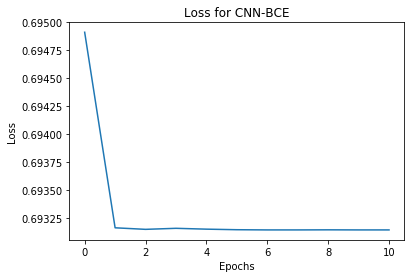

In [13]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images)
    labels = Variable(labels)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(time_list, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for CNN-BCE')
plt.show()

# MotionCouds generation
On va génerer en chunks et en 8 orientations avec 6 MC/par orientation :

In [1]:
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21
print('Btheta list : \n'+str( bw_values*180/np.pi))

theta_list = np.linspace(0,np.pi,16)


for chunk_index, chunk in enumerate(bw_subsets) : #split into ranges
    for t in theta_list :
        if not os.path.exists('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t)): #si le folder n'existe pas on le crée
            os.makedirs('./clouds_boundary_BCE/chunk%s/%s' % (chunk_index,t))

        for i_ax, B_theta in enumerate(chunk):
            mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0., B_V=0, theta=t, B_theta=B_theta)
            im = mc.random_cloud(mc_i)

            imageio.imwrite('./clouds_boundary_BCE/chunk%s/%s/B0 %s.png' % (chunk_index , t, (B_theta*180/np.pi) ) , im[:, :, 0])

            #plt.imshow(im[:, :, 0], cmap=plt.gray())
            #plt.text(5, 29, r'$B_\theta=%.1f$°' % (B_theta*180/np.pi), color='yellow', fontsize=32)
            #plt.show()  

Btheta list : 
[  1.40625      1.42925612   1.45263862   1.47640365   1.50055748
   1.52510646   1.55005706   1.57541585   1.60118951   1.62738482
   1.65400868   1.68106811   1.70857023   1.73652228   1.76493163
   1.79380574   1.82315224   1.85297884   1.8832934    1.91410391
   1.94541847   1.97724534   2.00959289   2.04246964   2.07588426
   2.10984553   2.14436241   2.17944398   2.21509948   2.2513383
   2.28816999   2.32560424   2.36365091   2.40232002   2.44162175
   2.48156645   2.52216465   2.56342703   2.60536446   2.64798798
   2.69130882   2.73533838   2.78008827   2.82557025   2.87179632
   2.91877864   2.96652959   3.01506174   3.06438787   3.11452097
   3.16547425   3.21726111   3.26989521   3.32339039   3.37776075
   3.4330206    3.4891845    3.54626723   3.60428384   3.66324959
   3.72318001   3.78409089   3.84599827   3.90891844   3.97286799
   4.03786374   4.10392282   4.17106261   4.23930081   4.30865538
   4.37914458   4.45078698   4.52360145   4.59760715   4.67282

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.9694763126109897e+177, 4.628975023930663e+177]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.585337814354489e+171, 7.540808550127552e+171]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.4980688891997745e+166, 2.3748943132624726e+166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.869706280405341e+160, 8.663933756219155e+160]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anacon

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.073202464137445e+150, 4.4061508347837754e+150]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.8805528258303556e+177, 4.310358113552701e+177]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.879925710954669e+171, 7.570746879339961e+171]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.624548831323575e+166, 2.5927880021866223e+166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anacon

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.465551222132201e+177, 4.902763113271224e+177]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.30730202896833e+171, 7.835596755383992e+171]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.313907485971152e+166, 2.7545449013556318e+166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9.843712257518746e+160, 1.0316342623719772e+161]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.073257494072447e+127, 6.863646879036257e+127]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.8835921276251553e+123, 3.715311581589214e+123]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.869010630601193e+145, 6.219072647175723e+145]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.2506340278453221e+141, 1.3659720152452585e+141]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anacon

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.979772759109851e+145, 7.087628582610129e+145]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.259493202488105e+141, 1.20623853040003e+141]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.4956013993274107e+136, 3.3663654080420084e+136]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.132789361333356e+132, 1.0796152195505317e+132]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anacond

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.085475414580102e+101, 1.861736107848089e+101]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.221884545120602e+119, 4.274313393588392e+119]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.450938170281282e+115, 5.050806950035264e+115]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.209656656959906e+111, 7.907672032936836e+111]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.933794612308348e+119, 4.736357342723705e+119]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.709763490614708e+115, 4.899095645820119e+115]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.2282722398538598e+112, 8.477153360951499e+111]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.0252971671694473e+108, 1.637029404207757e+108]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anacond

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.2963277359092385e+101, 2.203461603763894e+101]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.438330411580306e+119, 3.9653704321500154e+119]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.2598885834666e+115, 5.7165676253371705e+115]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.444786969751562e+111, 8.086860855413306e+111]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.819268015444402e+91, 5.7972846693432245e+91]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.702694450850607e+88, 4.70486401849893e+88]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.049078161571568e+85, 6.673875298513715e+85]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.320235290984871e+82, 1.0202123055274924e+83]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/py

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9.955309626321413e+97, 1.188451619685613e+98]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.511577190483162e+94, 6.5621519584459984e+94]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.965394968574016e+91, 4.928904833935246e+91]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.245134242885952e+88, 5.2660607631758476e+88]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.4437560309190718e+80, 1.4646331032237942e+80]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.009643775866337e+77, 4.301204722379665e+77]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0963026368513233e+75, 9.715151153226689e+74]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.3409833835745326e+72, 3.419268166737161e+72]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.456443931187308e+67, 7.424341404414315e+67]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.9803791787349483e+80, 1.7487045203902957e+80]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.3824711705599914e+77, 3.6634928084159247e+77]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0748223146704949e+75, 1.163978190634038e+75]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/li

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.579647159502613e+77, 3.5431421091686694e+77]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.113629595535616e+75, 1.1366009404879327e+75]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.486626512622602e+72, 4.720575886199407e+72]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.6039693458959038e+70, 1.4592245647983188e+70]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.95578722341224e+65, 4.1897993806687963e+65]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.3258938016773555e+63, 2.8071731051461253e+63]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.3523600964725936e+61, 2.4322359515783083e+61]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.412165384409877e+59, 2.4479009766636472e+59]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/li

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.0581892122876134e+57, 2.4227007501515708e+57]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.4241660660316835e+55, 2.731308916913279e+55]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.714556823792171e+65, 4.0949926495570155e+65]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.9117725309613334e+63, 2.5643742518601474e+63]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/l

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.607861981741505e+57, 2.2189848665018808e+57]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.971215899276024e+55, 2.5179021121466627e+55]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.875064467316186e+53, 4.580448222862917e+53]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.793143010056912e+51, 7.122153185919393e+51]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.01992896038929e+51, 6.858381502570699e+51]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.5368725873534735e+50, 1.4817062291759642e+50]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.152729407668064e+48, 3.253961445217733e+48]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.612079357000267e+46, 7.029926443169542e+46]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/py

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.047092512671882e+45, 2.0521059387409918e+45]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.817399652520874e+53, 3.850650419481859e+53]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.334165435029498e+51, 6.052086830204491e+51]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.546193828531554e+50, 1.3510846036836528e+50]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.3742113725138006e+38, 1.1627021895478422e+38]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.696376838995856e+36, 6.637502238042921e+36]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.551635430463338e+43, 4.870587400208886e+43]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.5480126647988466e+42, 1.689554219174438e+42]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.880697591663537e+40, 6.911502510629921e+40]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.296212594507674e+39, 2.9294242821579434e+39]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.3503065935848844e+38, 1.339250992154216e+38]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.875195150881874e+36, 6.069908599633868e+36]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.087878676427347e+43, 4.643476312674175e+43]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.973419962783559e+42, 1.967574481595197e+42]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.127039808216859e+40, 6.063528730230808e+40]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.8762081914816734e+39, 3.206449354065295e+39]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/py

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9.430865007190945e+30, 9.204732631420894e+30]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.889912316685601e+29, 8.123846929574097e+29]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.911301064506343e+35, 4.844632594825217e+35]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.69978401424451e+34, 2.355155396060371e+34]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/pyth

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.78965691109792e+35, 3.885734543742538e+35]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.3334419261660597e+34, 2.3005806218715184e+34]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.494108028765859e+33, 1.518225859380075e+33]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.5033142988225786e+32, 1.331862070807133e+32]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.047762311224107e+28, 8.499272159205916e+28]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.380594497365189e+27, 8.076625808585501e+27]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.577272908090334e+26, 1.0969367165481623e+27]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0876523303749483e+26, 1.000648790596352e+26]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.5360902318007353e+24, 1.859721328197283e+24]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.424561372845694e+28, 8.775487887578479e+28]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.090381025961032e+27, 8.780871071205958e+27]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9.788114102158017e+26, 8.330944571980635e+26]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/py

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0110062383420993e+28, 9.081151329166994e+27]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.779835603868837e+26, 9.554617230497854e+26]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0140081584665813e+26, 8.60791692801734e+25]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.3929930724044523e+25, 1.3409571791663026e+25]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.300294163988094e+19, 3.764208632929303e+19]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.5647077359981854e+23, 2.3125769225261074e+23]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.6400500979568262e+22, 3.59127892580244e+22]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.514517524961782e+21, 6.599502017022805e+21]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.1543507323929011e+21, 1.0633897862655459e+21]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.965099263331409e+20, 2.0546566701680086e+20]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.136852841089554e+19, 3.915289999289136e+19]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.6700244326165455e+23, 2.3595882800458e+23]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.195917408929346e+22, 4.274036299276164e+22]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.964344247730894e+21, 6.607347129665909e+21]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9.447782473216119e+20, 1.0526593917569434e+21]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.75834914433989e+20, 1.80727646565355e+20]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/pyth

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.902526201112527e+18, 8.870775072485151e+18]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.4899875929266964e+18, 1.6137980073253775e+18]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.845713880259817e+17, 3.311328385041907e+17]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.73924058343929e+16, 7.935383003347152e+16]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/py

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.044487978420224e+16, 1.7664720335320866e+16]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5911400298365478.0, 5162281689720229.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.704824131346448e+18, 6.592556147441454e+18]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.6112599692357256e+18, 1.644432564745688e+18]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4329124055112.8867, 3397649685626.53]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1538670633246116.0, 1523240935632492.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-419225340934537.6, 383810714083886.44]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-118961821679465.31, 130790912223663.06]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imagei

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-456383220722198.0, 419233614729952.0]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-138217915846766.16, 123485050025233.75]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-34000932757112.535, 33339306887037.49]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10841759099746.383, 9488237755720.883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1184405571077341.0, 1432853304330531.5]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-426610336709436.4, 412238411757715.5]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-111902786414062.73, 108528123496618.77]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-36321653522623.81, 37634585854883.52]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1271493778922.0437, 1151859004524.2383]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-394762204549.18005, 427470820658.58606]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-159730969636.21884, 151737285518.9886]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-71019647652.79698, 69693219081.76259]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imagei

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-23776653833.936005, 25175579672.86483]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8510178464.503641, 9350688980.336136]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1142100656788.6565, 1179031521246.0225]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-412216094196.6228, 461063506571.29224]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-66031849.02797936, 61061313.95520012]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3866324043.831708, 3243756948.575759]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1562724724.6246052, 1509830153.277927]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-842979328.6566701, 653556823.029278]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/cor

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-154613184.5160954, 133383732.99267384]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-83495861.84318396, 73481897.14088474]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3641771193.5529733, 3584963550.483807]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1993702387.6327832, 1596110140.076246]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2518697.2564595323, 2510738.2730020923]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1218427.1007368432, 1296525.883001346]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-32742009.722899355, 34101356.83506695]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-15326325.346519496, 15200606.655574668]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/image

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-38688840.95385812, 36283738.55377452]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-17595686.395458035, 16642443.15816984]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8626699.101395847, 8341113.004541003]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5436955.860122448, 4573571.801887689]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/co

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1184422.656418603, 1157818.030488278]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-36388449.08212646, 36826761.58451208]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-16185584.43635371, 16579984.9429813]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-9132506.489861751, 10107093.56262334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-81839.83149007756, 80042.2800985822]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-41467.905483925744, 43409.87019585223]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-680879.1033113669, 679368.0477811497]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-365908.1933629927, 397035.6326294082]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/cor

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-245115.97363839854, 221314.9362984247]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-125038.27738643669, 121760.13892898383]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-78796.15214245972, 82011.07096875992]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-48651.26415907458, 51818.77572695531]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2599.167074655882, 2726.615054899015]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-24191.856095168863, 28180.896272189282]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-17324.712722848068, 20703.921946884737]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10222.569548603018, 10071.29114621286]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imagei

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2661.9140993077176, 2884.67647905719]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-27825.852362011174, 24296.965675227642]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-16937.124055121167, 22029.07121205842]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10464.37662294444, 10318.697094616069]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4366.337226351911, 5311.074317264825]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3013.047018929292, 2664.938007470004]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-28230.889663540274, 29213.21462696343]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-18051.191629189034, 14657.488205608888]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1804.05867489824, 1939.1509215088545]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1219.3616078530638, 1240.353439342654]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-868.1957591284495, 879.1244415128272]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-533.5196951287793, 591.3802782128319]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/co

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-458.8482146929275, 490.0683721810966]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-304.60001733609363, 304.55560982199006]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1901.706804865481, 2145.458233463044]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1357.842561202288, 1416.7205529684584]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-144.60989784049696, 134.09120136979647]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-85.8472676742365, 99.03912172658218]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-72.02428209107453, 67.394555041736]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-51.626620139586834, 48.408147914462916]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/co

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-158.9411726712665, 173.912855225962]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-131.05041980892724, 120.8424049781409]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-111.66323473507208, 88.55613210163902]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-70.6101005917781, 74.58126467746044]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/cor

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-223.0967460436708, 231.86615166899355]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-166.95617383132407, 168.6004890575959]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-115.81504098602005, 140.91199226715065]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-90.4672116141368, 86.88453993684058]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-43.33509890586834, 39.3171058498117]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-31.74114694780207, 30.28770280533466]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-23.404965111194343, 25.504524909975586]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-21.35747876147211, 20.110158334287576]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/c

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-11.050414033558395, 11.237678319020738]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-50.986191518581634, 42.71153879003651]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-29.739167023029335, 29.898970681967622]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-21.499346990242216, 23.78871338439743]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/image

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.14608628764946, 3.3897434677786507]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10.027918342758378, 8.904397987375345]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.197815568685389, 7.563249297351964]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-5.881883926090543, 7.484495490721228]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/co

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.574393871620713, 3.3936774800841976]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10.269279738351088, 8.815164366564721]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-7.240845774994965, 6.866655856340051]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-6.221390008256373, 5.6697217876825885]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-4.341322116007985, 4.72444286460154]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.691075933030776, 4.089420038714291]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-10.607120368104809, 8.945696098577091]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-8.590703707815162, 7.029355776858294]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/cor

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.3590386611172967, 1.2245305940037934]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.101212231661796, 2.956585951547553]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.3710815930553157, 2.4770710543873316]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.959911754483977, 1.834713211937021]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.9826200450101208, 1.6578733508932568]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.2762326147977454, 1.386664317996092]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-3.1031810323928237, 3.0512659192738836]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-2.360788628076353, 2.5647925076120357]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/image

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.1352143886562778, 1.1174321946393568]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.1236534314377216, 1.231325786634518]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.8984544034133286, 0.9915992485690175]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.7598228332898503, 0.6655966176359778]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imag

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.0895747828252875, 1.062722636526868]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.9922764134893248, 0.8880805601490002]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.8125418017467048, 0.9578101571062696]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.761607897528724, 0.75887957199494]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-1.2260740789282543, 1.0063396892814778]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.9812694839984591, 0.9286673761067736]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.8132897863676875, 0.7530178142339856]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.8744765974769035, 0.7080815046461597]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/ima

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.35411068542019497, 0.3769586018312614]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.3131215340078536, 0.328299299993454]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.27732866179274807, 0.27575864948250983]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.5066810753101642, 0.52804752706488]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/ima

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.3392510479509171, 0.3710615621041928]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.3270961324973659, 0.3548022949206141]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.31363508260460315, 0.30415318907910666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.5041220695532838, 0.4398720207934699]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/i

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.24838069332311635, 0.2811022410837094]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.27782812577678706, 0.24909167272807603]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.24821071742543616, 0.22856715163340033]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.2154735740702749, 0.1931013044608942]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-package

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.29528586028932835, 0.2760203396643866]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.24010263169572998, 0.2574539760569124]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.2139994274289434, 0.25089616873525833]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.22131864578429883, 0.19607997568233404]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-package

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.2697045519447157, 0.26854711401732456]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.21799843876404323, 0.24194904217679825]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.2167161509560326, 0.228568410222194]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.22065327421473335, 0.23025657437386782]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.10779914803660592, 0.10187956510738577]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.1666060284325071, 0.17513244805679873]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.16265210724123957, 0.14356896679162212]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.15382212830192687, 0.1592526516015687]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packag

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.12163642215374043, 0.1138221965783499]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.1487122443529979, 0.15260483997537327]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.13738402578390904, 0.15932799396631372]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.1610934229061822, 0.13743384561137081]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-package

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.08115489693542965, 0.09075733792524472]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.09443103668978847, 0.0784753537600148]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.10983489719844175, 0.112168717398491]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.10947882843030474, 0.09341824581847112]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-package

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.08959338522672614, 0.08295220773620297]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07416215634830321, 0.08132082203875529]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.10714694609292184, 0.12292591433809896]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.09631815602630983, 0.10274794664284967]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pack

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.08228245675599416, 0.0913182223375023]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.08600133295345644, 0.07712881334960797]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.10021046522319463, 0.10814805722232781]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.1017954977998088, 0.1139531717804593]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-package

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07029554770904121, 0.08079093074282025]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.06958136468854702, 0.07076980932100385]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07479220784848556, 0.06802143742077527]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07856330259041602, 0.08109821632055036]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pack

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07745229364222025, 0.08071439819229331]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.06938053205281086, 0.06830209483509045]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.06377643877104533, 0.06301315544788971]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.08056873524207177, 0.08191313829544111]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pack

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.06548242888150312, 0.07274211750732532]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.06078027869843987, 0.07467789488121931]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0600780331716853, 0.06761219558750234]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.07694433257491803, 0.08031331947507715]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.055575134138938526, 0.05665066273679907]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05706057986975563, 0.06116281669316924]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05583491181244836, 0.05270953373815837]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05181498705343909, 0.05190278913638795]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pac

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0606268861207261, 0.06589276491725618]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05795030650246129, 0.057393969275441714]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.060030776438098093, 0.05699547282365227]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05646198998856748, 0.060580612840938006]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.048774221337489675, 0.051842063182793705]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.048054574638434155, 0.05696652455541863]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05311797524310547, 0.04363799628306552]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04659590514384557, 0.052936603881501204]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05343547004558964, 0.04604142250472244]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.05725907524741104, 0.05115057323881004]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.047971708953753474, 0.045246359821023416]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04339922235346851, 0.05144229134451012]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04017368453692377, 0.04548150235706638]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.050472432057884244, 0.050087715730140286]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04718774525887623, 0.04768076341632663]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04635213977837192, 0.04309439349249302]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04426981456253194, 0.038272295031458445]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03606296743362603, 0.042060444157997014]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04001876781646775, 0.04160320410592533]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0459775401912942, 0.042787660329204544]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.043745848176143076, 0.04348783264892804]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04069229527513098, 0.04164587448858891]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04443493734976124, 0.04178819966081585]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03895181434759307, 0.03926966085298142]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pac

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03695658774084447, 0.03543616296469815]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04003781282628861, 0.037256472929485696]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03688969580866913, 0.03538392641242617]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.037757545074142876, 0.03374507772124366]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03821777089470998, 0.040028556217768546]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.039005356582903265, 0.03889731412513769]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.035377702008638504, 0.04627021410541928]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.04233145543760651, 0.036972165942671546]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03581693118826394, 0.039964341511111987]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03827118940026231, 0.037876907869532475]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.035926264233874246, 0.04175821934487639]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03935576759779866, 0.03271244382167118]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.035117640931086366, 0.037608059651306536]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.041762634494293426, 0.03811042297742158]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033904252949296394, 0.03701521784297178]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03582679191505454, 0.0371760113006426]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031878494814643756, 0.03418418586501733]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032090624004316275, 0.0363691423257455]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.036519780885400414, 0.03444777641619166]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033740435647853215, 0.032486803397404354]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.034876018497406285, 0.03176478546569875]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03223931740457471, 0.03404029168299831]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033955650466844275, 0.028730111127495947]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.035217990799110754, 0.034256263503832346]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03180551470008252, 0.03175578108939058]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0352113366738067, 0.036137553432364425]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03324443454396549, 0.03317687081890443]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03378876127664526, 0.033076916031736014]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pac

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030799979118685997, 0.034376134476789034]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.034712398620578816, 0.03541632808785594]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0395309168555406, 0.03361648803173404]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03666048524223966, 0.03255751292755976]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03389386742533188, 0.031193919814340783]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03104846901492724, 0.03144964691346702]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03315438658730842, 0.02873559686207093]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029253171336601255, 0.03360848239027306]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031376038969115755, 0.027645109558617355]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033825040996192386, 0.03191233873752372]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030668518544866356, 0.030493663005026102]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03265047923483605, 0.03286845395436064]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.036370635878093034, 0.029056186030364663]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032119560063894756, 0.03447431166548241]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03177755939084638, 0.035328771594209336]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032868307831457944, 0.03185017089422103]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03459162330370024, 0.03483762245278914]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03022978465612717, 0.03067202286598677]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0306525611222868, 0.0288588322654875]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032008329542093705, 0.03265372354158802]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03230292571037695, 0.0327006784297822]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02949895374704714, 0.028255389917430873]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031004882378941147, 0.029411642806974024]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03542103892367507, 0.02789783891091642]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0342942764576389, 0.032083213584997855]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03108076714366435, 0.03148209752004988]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03006368490369354, 0.03103557286758267]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031084558122947588, 0.040551001822969626]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02871359357273034, 0.030203141933864697]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029419450105761285, 0.035140683668305014]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03236185204641012, 0.02877464511067268]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031224240336031352, 0.027537664847192257]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03500820375095111, 0.029314173994128587]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03055226253061344, 0.03228413512844517]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02841045200958242, 0.02913504110888883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03161398075844282, 0.031190460938665128]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03140366513333621, 0.029604958789237138]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0312609846440077, 0.029102635422924683]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030246236862170258, 0.02950471331811372]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03016652646173104, 0.02987185953336956]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030902669264444967, 0.03180628892320525]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03250772098345768, 0.031495294226970165]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03171466906080281, 0.030255396023792215]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033061243727574186, 0.028772317666746636]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028882826232338503, 0.030365755044697133]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028637882664621857, 0.030022717894182184]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028913893352418635, 0.03389513008240666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031053237693603023, 0.03188143982358453]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/sit

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031715840479384465, 0.02737846283526224]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.033372514434509865, 0.028726054255023125]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03611051788087965, 0.028806032649851612]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027790371845695657, 0.028851374421565025]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/sit

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030142749765890785, 0.02847552994921752]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02976581971751998, 0.029835750595956712]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03204665683874442, 0.030817989771743284]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029119860813719943, 0.02923705428834434]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032695080091888665, 0.031472449064112916]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029436607387673428, 0.029439032209401396]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027917486629244107, 0.02956330543349042]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027064948199017336, 0.032191621735317866]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/si

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028506994999581533, 0.0278030633170272]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027052221298952968, 0.028433511440852627]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026465577812416638, 0.029273942326168274]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02943635155842166, 0.030675701950922177]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029555297479959736, 0.0295908404034846]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02932794520668614, 0.02657630337012116]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02901304083744015, 0.027277590508384828]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026620181688576616, 0.03015016570595883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031943937471386755, 0.027347141062722704]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02924255667005205, 0.029860624369629087]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032944763094243074, 0.030963844648905458]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0290996848904257, 0.027060173792007]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029166893838344164, 0.030256591606711507]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03388581134384232, 0.030847317379275666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03184170815465838, 0.029582426571734374]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03213288316676395, 0.030520838393021242]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029090244549416958, 0.027776171137668823]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02852899657921635, 0.026886578826809997]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03348273189315186, 0.03005525439189599]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.025903867628630374, 0.028255303174650727]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030990946949985172, 0.025571143201953216]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0283445074753944, 0.028859661052702264]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029686302241425204, 0.029974998302443007]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031190530985424875, 0.030965106386153504]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/sit

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02723514684753458, 0.02756011674212667]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029287689302186594, 0.029637116600518883]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030873035250123484, 0.030226603411232893]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03070626247822877, 0.02709446045291778]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032500402083550456, 0.03005440254818679]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030605954836128976, 0.03033100563133178]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03505771985180453, 0.029384879772284406]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03116938224389437, 0.031250638909007464]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028350301833287767, 0.03203720884914381]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03129655077660026, 0.03054831739847384]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02798477495571656, 0.02885530863037542]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03047034531257886, 0.02860220696202294]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pac

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03147443380602681, 0.0323590728645008]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029526945433497306, 0.02803582482245915]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03231141958874571, 0.028772113742590144]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028243443184237525, 0.027309633116852597]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029618351841989306, 0.029778441939632395]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030808531951930528, 0.027780614632995006]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026985741060306302, 0.03700749355385568]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028505345091028422, 0.028188569098876435]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/si

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02913972565811242, 0.03174076711641857]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031071457840704666, 0.025866631656815204]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027283657345857748, 0.02991436559407472]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03237950195611676, 0.030422229814416456]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0269155722163577, 0.03406642590888541]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029388786427722566, 0.03216915192069178]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02881234730776767, 0.032615085564627486]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027961194303645888, 0.03155754114142656]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031055836826292878, 0.0310117348403555]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03414307652289737, 0.030463329938679982]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02855395404847508, 0.03014044458286521]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030539156550293885, 0.03132209004602916]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03006356110516881, 0.027866283608251954]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02944685449623964, 0.027996601623255297]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027791263496605666, 0.032051999420157726]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03269615767865084, 0.028227557384644646]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026812572216725748, 0.026878562083673334]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027558385440694742, 0.03643859528203384]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028801467601397783, 0.02817310341814209]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.032772321112002914, 0.03023164519405186]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02669919092608541, 0.029371223787760043]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02932822318958031, 0.02655158332341892]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027819701336083677, 0.029930873976448877]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.031487609197110175, 0.02914251943634246]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02816784039633939, 0.029233101878747118]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02995771737698327, 0.026797834947823344]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026391903224876744, 0.02902554253286478]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029902327443413434, 0.03076812299031701]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03063424215659706, 0.028948620190457863]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028887019242558418, 0.03152391353639268]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03193385857458886, 0.030461451724017666]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030569511586920516, 0.03105382037720327]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030207973445337093, 0.02845524469781769]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02721847982354643, 0.028449839369822462]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03040531036055125, 0.03142222323796019]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03106045748334302, 0.029008511755263124]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-p

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02711177072913082, 0.02821104421095809]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02934622945160804, 0.031557777045509924]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027034599154195545, 0.0300559821921195]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02640018430338366, 0.028054044321909874]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pa

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0284236577786659, 0.027816574577050175]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027304707197074774, 0.027194796006503555]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029932747690029696, 0.029696300433687248]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029882539101009832, 0.028942180048676328]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/sit

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030239107942980896, 0.028423588972142692]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030167906375079868, 0.029109676544537375]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.03239701326700162, 0.030497001301797073]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.026815912394309194, 0.029585911219269838]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/si

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030779839571954536, 0.029247153214416555]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.030192881761887228, 0.03091092219718473]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.029888980439015014, 0.026060940352835443]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.028866360283300453, 0.031566252687004255]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/si

/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02804995636621247, 0.02807978740821452]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.027675780825237223, 0.030618695458419564]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.0315301725140513, 0.03125895498303034]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [-0.02903119951504375, 0.02980992425255919]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/home/hugo/anaconda3/lib/python3.6/site-pac

On crée des fonctions pour extraires les informations de l'image : 

On défini le réseau :

In [3]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch 
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(1690, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 16)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = self.sigm(x)
        return x


model = Net()
print(model)



Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1690, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=16, bias=True)
  (sigm): Sigmoid()
)


On entraine sur du easy avec le CEL avant de passer au classification de B_theta : 

In [ ]:
import torch.optim as optim

def one_hot_v3(batch,depth):
    emb = nn.Embedding(depth, depth)
    emb.weight.data = torch.eye(depth)
    return emb(batch)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=8,shuffle=True,
                                             num_workers=1)

total_step = len(train_loader)
loss_list = []
time_list = []
t=0

epochs = 10

import time
start_time = time.time()
print("Started training")

for epoch in range(epochs) :
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)
        labels = one_hot_v3(labels,16)
        
        # Forward pass
        outputs = model(images)
        #print(outputs.size())

        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Started training
Epoch [1/10], Step [100/480], Loss: 0.6931
Epoch [1/10], Step [200/480], Loss: 0.6931
Epoch [1/10], Step [300/480], Loss: 0.6931
Epoch [1/10], Step [400/480], Loss: 0.6823
Epoch [2/10], Step [100/480], Loss: 0.6725
Epoch [2/10], Step [200/480], Loss: 0.6769
Epoch [2/10], Step [300/480], Loss: 0.6769


Et maintenant on teste sur les chunks :

In [6]:
import math
import numpy as np
import MotionClouds as mc
import matplotlib.pyplot as plt
import os
import imageio

downscale = 1
fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)

N_theta = 300
nbr_chunks = 50 

bw_values = np.pi*np.logspace(-7,0, N_theta, base=2)
bw_subsets = np.array_split(bw_values, nbr_chunks)

fig_width = 21

theta_list = np.linspace(0,np.pi,16)

ez_range_list = []
ez_acc_list = []

for chunk_index, chunk in enumerate(bw_subsets):
    test_loss = 0
    correct = 0
    data_set = datasets.ImageFolder(root='clouds_boundary_BCE/chunk%s'%chunk_index,
                                transform=data_transform)
    data_loader = torch.utils.data.DataLoader(data_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)
    
    #labels is (theta-thetamean)/4btheta²
    for data, target in data_loader:
        data = Variable(data, volatile=True)
        
        #NEW LABEL
        B_theta = np.mean(chunk)*180/np.pi
        #print('Mean B_theta = %s' %B_theta)
        
        Theta_zero = np.mean(np.linspace(0,np.pi,16))
        #print('Theta_zero = %s' % Theta_zero)
        
        target_list =[]
        for i,t in enumerate(target):
            Theta = data_set.classes[target[i]]
            target_list.append(float(Theta))
        #print('List of thetas = %s' % target_list)
        
        new_label = []
        for lab in range(len(target_list)):
            new_lab = math.cos(target_list[lab]-Theta_zero)
            new_lab = new_lab/4 * (B_theta) **2
            print(new_lab)
            new_label.append(int(new_lab))
            
        #print('New labels %s' % new_label)
        new_label = torch.LongTensor(new_label)
        new_label = Variable(new_label)
        
        
            
        #rescale
        net_out = model(data)
        

        #somme des pertes du batch
        test_loss += criterion(net_out, new_label).data[0]
        pred = net_out.data.max(1)[1] #index of max_log probability
        correct += pred.eq(new_label.data).sum() #sum up pred equals target in the batch
    
    test_loss /= len(data_loader.dataset) #loss = loss/length set
    #print("Chunk b_theta range : %s : %s" % (chunk[1]*180/np.pi, chunk[-1]*180/np.pi))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    ez_range_list.append( ( chunk[1]*180/np.pi + chunk[-1]*180/np.pi ) / 2 )
    ez_acc_list.append(100 * correct /len(data_loader.dataset))


3.28561819466484e-17
3.28561819466484e-17
3.28561819466484e-17
3.28561819466484e-17
3.28561819466484e-17
3.28561819466484e-17
0.11156170656061402
0.11156170656061402
0.11156170656061402
0.11156170656061402
0.11156170656061402
0.11156170656061402
0.21824763121206683
0.21824763121206683
0.21824763121206683
0.21824763121206683
0.21824763121206683
0.21824763121206683
0.3153950871112252
0.3153950871112252
0.3153950871112252
0.3153950871112252
0.3153950871112252
0.3153950871112252
0.3987582642700824
0.3987582642700824
0.3987582642700824
0.3987582642700824
0.3987582642700824
0.3987582642700824
0.4646937918258905
0.4646937918258905
0.4646937918258905
0.4646937918258905
0.4646937918258905
0.4646937918258905
0.5103199708306962
0.5103199708306962
0.5103199708306962
0.5103199708306962
0.5103199708306962
0.5103199708306962
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.533642718323292
0.53364271832329

1.1628716608299514
1.1628716608299514
1.1628716608299514
1.1628716608299514
1.1628716608299514
1.1628716608299514
1.1120485891743541
1.1120485891743541
1.1120485891743541
1.1120485891743541
1.1120485891743541
1.1120485891743541
1.0126236579706647
1.0126236579706647
1.0126236579706647
1.0126236579706647
1.0126236579706647
1.0126236579706647
0.8689422138062369
0.8689422138062369
0.8689422138062369
0.8689422138062369
0.8689422138062369
0.8689422138062369
0.6872838252511193
0.6872838252511193
0.6872838252511193
0.6872838252511193
0.6872838252511193
0.6872838252511193
0.47558783557883244
0.47558783557883244
0.47558783557883244
0.47558783557883244
0.47558783557883244
0.47558783557883244
0.24310637536811794
0.24310637536811794
0.24310637536811794
0.24310637536811794
0.24310637536811794
0.24310637536811794
7.159757185271507e-17
7.159757185271507e-17
7.159757185271507e-17
7.159757185271507e-17
7.159757185271507e-17
7.159757185271507e-17

Test set: Average loss: 2.4212, Accuracy: 48/96 (50%)

8.

1.8956134997487995e-16
1.8956134997487995e-16
1.8956134997487995e-16
1.8956134997487995e-16
1.8956134997487995e-16
1.8956134997487995e-16
0.6436471448651891
0.6436471448651891
0.6436471448651891
0.6436471448651891
0.6436471448651891
0.6436471448651891
1.2591638209380973
1.2591638209380973
1.2591638209380973
1.2591638209380973
1.2591638209380973
1.2591638209380973
1.8196489958976336
1.8196489958976336
1.8196489958976336
1.8196489958976336
1.8196489958976336
1.8196489958976336
2.3006067780918
2.3006067780918
2.3006067780918
2.3006067780918
2.3006067780918
2.3006067780918
2.6810170045472166
2.6810170045472166
2.6810170045472166
2.6810170045472166
2.6810170045472166
2.6810170045472166
2.944253922956989
2.944253922956989
2.944253922956989
2.944253922956989
2.944253922956989
2.944253922956989
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168357307
3.0788128168

6.415883383646003
6.415883383646003
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.70910339589663
6.415883383646003
6.415883383646003
6.415883383646003
6.415883383646003
6.415883383646003
6.415883383646003
5.842258480705827
5.842258480705827
5.842258480705827
5.842258480705827
5.842258480705827
5.842258480705827
5.013298847892265
5.013298847892265
5.013298847892265
5.013298847892265
5.013298847892265
5.013298847892265
3.9652339989489116
3.9652339989489116
3.9652339989489116
3.9652339989489116
3.9652339989489116
3.9652339989489116
2.7438693969477206
2.7438693969477206
2.7438693969477206
2.7438693969477206
2.7438693969477206
2.7438693969477206
1.4025845357537425
1.4025845357537425
1.4025845357537425
1.4025845357537425
1.4025845357537425
1.4025845357537425
4.13076978857813e-16
4.13076978857813e-16
4.13076978857813e-16
4.13076978857813e-16
4.13076978

9.001444149079424e-16
9.001444149079424e-16
9.001444149079424e-16
9.001444149079424e-16

Test set: Average loss: 1.7563, Accuracy: 12/96 (12%)

1.093660409558464e-15
1.093660409558464e-15
1.093660409558464e-15
1.093660409558464e-15
1.093660409558464e-15
1.093660409558464e-15
3.713475347995155
3.713475347995155
3.713475347995155
3.713475347995155
3.713475347995155
3.713475347995155
7.264654004051186
7.264654004051186
7.264654004051186
7.264654004051186
7.264654004051186
7.264654004051186
10.49833242045265
10.49833242045265
10.49833242045265
10.49833242045265
10.49833242045265
10.49833242045265
13.273183333492188
13.273183333492188
13.273183333492188
13.273183333492188
13.273183333492188
13.273183333492188
15.467932443057988
15.467932443057988
15.467932443057988
15.467932443057988
15.467932443057988
15.467932443057988
16.986658681487338
16.986658681487338
16.986658681487338
16.986658681487338


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /opt/conda/conda-bld/pytorch-cpu_1518282373170/work/torch/lib/THNN/generic/ClassNLLCriterion.c:87

Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7f9e981d0e48>>
Traceback (most recent call last):
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 333, in __del__
    self._shutdown_workers()
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 319, in _shutdown_workers
    self.data_queue.get()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/hugo/anaconda3/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/hugo/anaconda3/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c 

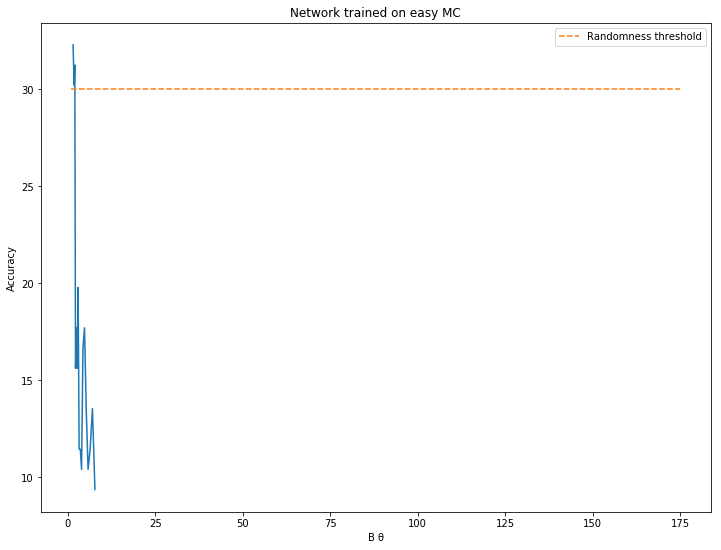

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 9]
plt.ylabel("Accuracy")
plt.xlabel("B θ")
plt.title("Network trained on easy MC")

plt.plot(ez_range_list, ez_acc_list)
plt.plot([1,175],[30,30],'--', label = 'Randomness threshold')
plt.legend()
plt.show()

# Test

In [62]:
import math
cos = math.cos(0-0.62)
div = cos/(4*(1.4)**2)
print(div)
print(0)

0.1038110276355273
0


In [82]:
lis = list(train_set[0])
lis[1] = 3 
lis = tuple(lis)
print(lis)
train_set[0] = lis

(
(0 ,.,.) = 
 -0.1686 -0.1686 -0.1608  ...  -0.1843 -0.1765 -0.1765
 -0.0118 -0.0118 -0.0118  ...  -0.0039 -0.0039 -0.0039
  0.1294  0.1294  0.1294  ...   0.1294  0.1294  0.1294
           ...             ⋱             ...          
  0.1529  0.1529  0.1608  ...   0.1451  0.1529  0.1529
  0.0275  0.0275  0.0275  ...   0.0353  0.0353  0.0353
  0.0588  0.0667  0.0667  ...   0.0667  0.0667  0.0667
[torch.FloatTensor of size 1x64x64]
, 3)


TypeError: 'ImageFolder' object does not support item assignment

In [16]:
from torchvision import datasets

class CustomImageFolder(datasets.ImageFolder):
    print('Custom Image Loading') 
    
    def __init__(self, root, transform=data_transform, target_transform=None,
                 loader=default_loader):
        super(CustomImageFolder, self).__init__(root, loader, IMG_EXTENSIONS,
                                          transform=transform,
                                          target_transform=target_transform)
        self.imgs = self.samples
        
CustomImageFolder(root = '16_clouds_easy', transform = data_transform)

Custom Image Loading


TypeError: __init__() got multiple values for argument 'transform'

In [5]:
import torch.utils.data as data

from PIL import Image

import os
import os.path


def has_file_allowed_extension(filename, extensions):
    """Checks if a file is an allowed extension.
    Args:
        filename (string): path to a file
        extensions (iterable of strings): extensions to consider (lowercase)
    Returns:
        bool: True if the filename ends with one of given extensions
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in extensions)


def is_image_file(filename):
    """Checks if a file is an allowed image extension.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    print(classes)
    print(class_to_idx)
    return classes, class_to_idx


def make_dataset(dir, class_to_idx, extensions):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if has_file_allowed_extension(fname, extensions):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)

    return images


class DatasetFolder(data.Dataset):
    """A generic data loader where the samples are arranged in this way: ::
        root/class_x/xxx.ext
        root/class_x/xxy.ext
        root/class_x/xxz.ext
        root/class_y/123.ext
        root/class_y/nsdf3.ext
        root/class_y/asd932_.ext
    Args:
        root (string): Root directory path.
        loader (callable): A function to load a sample given its path.
        extensions (list[string]): A list of allowed extensions.
        transform (callable, optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.RandomCrop`` for images.
        target_transform (callable, optional): A function/transform that takes
            in the target and transforms it.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        samples (list): List of (sample path, class_index) tuples
        targets (list): The class_index value for each image in the dataset
    """

    def __init__(self, root, loader, extensions, transform=None, target_transform=None):
        classes, class_to_idx = find_classes(root)
        samples = make_dataset(root, class_to_idx, extensions)
        if len(samples) == 0:
            raise(RuntimeError("Found 0 files in subfolders of: " + root + "\n"
                               "Supported extensions are: " + ",".join(extensions)))

        self.root = root
        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif']


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [8]:
x= find_classes('16_clouds_easy')

['0.0', '0.20943951023931953', '0.41887902047863906', '0.6283185307179586', '0.8377580409572781', '1.0471975511965976', '1.2566370614359172', '1.4660765716752366', '1.6755160819145563', '1.8849555921538759', '2.0943951023931953', '2.3038346126325147', '2.5132741228718345', '2.722713633111154', '2.9321531433504733', '3.141592653589793']
{'0.0': 0, '0.20943951023931953': 1, '0.41887902047863906': 2, '0.6283185307179586': 3, '0.8377580409572781': 4, '1.0471975511965976': 5, '1.2566370614359172': 6, '1.4660765716752366': 7, '1.6755160819145563': 8, '1.8849555921538759': 9, '2.0943951023931953': 10, '2.3038346126325147': 11, '2.5132741228718345': 12, '2.722713633111154': 13, '2.9321531433504733': 14, '3.141592653589793': 15}


In [125]:
class CustomImageFolder(DatasetFolder):
    """A generic data loader where the images are arranged in this way: ::
        root/dog/xxx.png
        root/dog/xxy.png
        root/dog/xxz.png
        root/cat/123.png
        root/cat/nsdf3.png
        root/cat/asd932_.png
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
     Attributes:
        classes (list): List of the class names.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples
    """
    def __init__(self, root,transform=None, target_transform=None,
                 loader=default_loader):
        super(ImageFolder, self.as_super).__init__(root, loader, IMG_EXTENSIONS,
                                          transform=transform,
                                          target_transform=target_transform)
        self.imgs = self.samples

In [4]:
custom_test_set = DatasetFolder(root = '16_clouds_easy', loader = default_loader, extensions = IMG_EXTENSIONS, 
                               transform = data_transform)
custom_test_loader = torch.utils.data.DataLoader(custom_test_set,
                                             batch_size=8, shuffle=True,
                                             num_workers=1)
for i, (a,b) in enumerate(custom_test_loader) :
    print(b)


  0
 12
  0
  4
 12
 15
  6
 15
[torch.LongTensor of size 8]


 12
 10
 14
 13
 14
  3
 11
  2
[torch.LongTensor of size 8]


 13
  8
  7
  9
  0
  5
 10
 10
[torch.LongTensor of size 8]


  2
 13
  6
 12
  9
  8
 14
  0
[torch.LongTensor of size 8]


  6
 15
  9
  3
  6
  6
  6
 12
[torch.LongTensor of size 8]


  9
  4
  2
  5
 14
 10
 12
  7
[torch.LongTensor of size 8]


 12
  5
 14
  0
 15
 11
  2
  8
[torch.LongTensor of size 8]


 14
  0
  9
  9
  2
 12
  2
  5
[torch.LongTensor of size 8]


  9
  0
 12
  8
  1
  4
 14
  5
[torch.LongTensor of size 8]


 13
 12
  9
  6
 10
  0
  8
  1
[torch.LongTensor of size 8]


  2
  0
 10
  6
  0
  1
  9
  4
[torch.LongTensor of size 8]


 10
  7
  0
  4
  2
  4
  9
  1
[torch.LongTensor of size 8]


 13
  9
 11
  7
  1
 14
  8
  7
[torch.LongTensor of size 8]


  2
 15
  9
 12
 14
  9
 13
 12
[torch.LongTensor of size 8]


  3
  4
  3
  5
  5
  7
 12
  5
[torch.LongTensor of size 8]


  9
  3
  4
  1
  5
 10
  3
 10
[torch.LongTensor of s


  2
 10
  8
 15
  7
 12
  0
 15
[torch.LongTensor of size 8]


  4
 10
  5
  1
  7
  1
  0
  9
[torch.LongTensor of size 8]


 14
  7
 10
 12
  2
  6
 15
 11
[torch.LongTensor of size 8]


  3
 10
 12
 10
 13
  2
 10
  2
[torch.LongTensor of size 8]


  6
  3
  2
 15
 15
 14
 11
 11
[torch.LongTensor of size 8]


 15
 14
  4
  0
  2
 11
  6
  4
[torch.LongTensor of size 8]


  9
 11
  9
 15
 11
  1
  3
  1
[torch.LongTensor of size 8]


 11
  6
  9
 12
  2
  3
 13
 12
[torch.LongTensor of size 8]


 15
 15
  5
  5
 10
 12
  4
 14
[torch.LongTensor of size 8]


  6
  1
  1
  1
 13
 13
  6
  5
[torch.LongTensor of size 8]


 11
  8
  4
 14
  2
 13
  7
  4
[torch.LongTensor of size 8]


  6
 14
 15
  8
 14
 15
  4
 11
[torch.LongTensor of size 8]


 10
 10
  5
  6
 15
  4
 12
 15
[torch.LongTensor of size 8]


 15
  1
  3
  3
  5
  1
  2
  4
[torch.LongTensor of size 8]


 10
 12
 10
  2
 12
  2
  0
 12
[torch.LongTensor of size 8]


  6
  1
  0
  4
  6
  2
  1
 14
[torch.LongTensor of s


  9
 14
  2
  5
 11
  6
 14
  5
[torch.LongTensor of size 8]


  7
  0
  8
 12
  6
  7
 14
 12
[torch.LongTensor of size 8]


 3
 3
 1
 5
 3
 7
 6
 0
[torch.LongTensor of size 8]


  3
  2
 14
 15
  4
  9
 13
 10
[torch.LongTensor of size 8]


  0
 11
  0
 12
 12
 13
  3
  1
[torch.LongTensor of size 8]


  5
  1
 12
  7
  5
 10
  5
  5
[torch.LongTensor of size 8]


 15
  8
  3
 14
 10
  0
  3
  0
[torch.LongTensor of size 8]


  1
  5
  6
  3
 12
 13
  2
  3
[torch.LongTensor of size 8]


  3
  9
  0
  1
 12
 13
  6
  9
[torch.LongTensor of size 8]


  6
 14
 14
 13
  9
 11
  0
  3
[torch.LongTensor of size 8]


  7
 14
  3
  1
  1
 15
  6
  1
[torch.LongTensor of size 8]


  2
 11
  1
  5
  7
  4
  6
  9
[torch.LongTensor of size 8]


  6
  4
  6
  4
  5
 10
  5
 14
[torch.LongTensor of size 8]


 13
  2
  1
  6
 11
  0
  5
  7
[torch.LongTensor of size 8]


  7
  5
  7
 11
 10
  5
  7
  8
[torch.LongTensor of size 8]


  7
  8
  8
 10
 15
  7
  8
  5
[torch.LongTensor of size 8]




  8
  1
  0
 10
  5
  7
  8
 15
[torch.LongTensor of size 8]


  2
  1
  3
  1
  6
  2
 15
  5
[torch.LongTensor of size 8]


  4
 11
  5
 14
 15
  9
  8
  6
[torch.LongTensor of size 8]


 11
  2
 12
 12
 14
  6
 15
  4
[torch.LongTensor of size 8]


  8
  0
 15
  9
 12
  8
  4
 15
[torch.LongTensor of size 8]


  4
  2
  8
 15
  6
 12
  7
  2
[torch.LongTensor of size 8]


  7
 11
  2
  4
  3
  8
 15
  5
[torch.LongTensor of size 8]


  0
  6
 10
  0
 10
 13
  0
 11
[torch.LongTensor of size 8]


  2
  3
  1
 10
  1
  0
  3
 13
[torch.LongTensor of size 8]


 4
 0
 5
 7
 2
 2
 6
 9
[torch.LongTensor of size 8]


 10
  6
 11
  9
  6
 15
  0
  8
[torch.LongTensor of size 8]


  6
 13
 15
  2
  2
  2
  8
  6
[torch.LongTensor of size 8]


  5
 11
 11
 12
 14
  0
 10
  7
[torch.LongTensor of size 8]


 14
  2
  5
  7
 15
  2
  5
 14
[torch.LongTensor of size 8]


  9
  8
 15
  7
  2
  9
  7
  5
[torch.LongTensor of size 8]


  7
 14
  9
 13
 15
  5
 12
 13
[torch.LongTensor of size 8]

